<a href="https://colab.research.google.com/github/Al-tekreeti/intrusion-detection/blob/main/Intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Mounted at /content/gdrive


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
!ls -la /content/gdrive/MyDrive/Mustafa/'Data Set'/BG-university/Danmini_Doorbell/gafgyt_attacks.rar

-rw------- 1 root root 55773915 Apr  6 15:29 '/content/gdrive/MyDrive/Mustafa/Data Set/BG-university/Danmini_Doorbell/gafgyt_attacks.rar'


In [3]:
benign_traffic = pd.read_csv('/content/gdrive/MyDrive/Mustafa/Data Set/BG-university/Danmini_Doorbell/benign_traffic.csv')
benign_traffic.shape

(49548, 115)

In [4]:
udp_attack_traffic = pd.read_csv('/content/gdrive/MyDrive/Mustafa/Data Set/BG-university/Danmini_Doorbell/mirai_attacks/udp.csv')
udp_attack_traffic.shape

(237665, 115)

In [ ]:
benign_traffic.columns == udp_attack_traffic.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [5]:
benign_traffic['Class'] = 0
udp_attack_traffic['Class'] = 1
udp_attack_traffic.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L5_weight,H_L5_mean,H_L5_variance,H_L3_weight,H_L3_mean,H_L3_variance,H_L1_weight,H_L1_mean,H_L1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,HH_L5_radius,HH_L5_covariance,HH_L5_pcc,HH_L3_weight,HH_L3_mean,HH_L3_std,...,HH_jit_L0.1_variance,HH_jit_L0.01_weight,HH_jit_L0.01_mean,HH_jit_L0.01_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc,HpHp_L3_weight,HpHp_L3_mean,HpHp_L3_std,HpHp_L3_magnitude,HpHp_L3_radius,HpHp_L3_covariance,HpHp_L3_pcc,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Class
0,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,...,0.0,1.0,1.507656e+09,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1
1,1.997781,60.0,0.000000e+00,1.998668,60.0,0.000000e+00,1.999556,60.0,4.547474e-13,1.999956,60.0,0.000000e+00,1.999996,60.0,0.000000e+00,1.997781,60.0,0.000000e+00,1.998668,60.0,0.000000e+00,1.999556,60.0,4.547474e-13,1.999956,60.0,0.000000e+00,1.999996,60.0,0.000000e+00,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,...,0.0,1.0,1.507656e+09,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1
2,2.997774,60.0,1.364242e-12,2.998664,60.0,4.547474e-13,2.999554,60.0,0.000000e+00,2.999955,60.0,4.547474e-13,2.999996,60.0,9.094947e-13,2.997774,60.0,1.364242e-12,2.998664,60.0,4.547474e-13,2.999554,60.0,0.000000e+00,2.999955,60.0,4.547474e-13,2.999996,60.0,9.094947e-13,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,...,0.0,1.0,1.507656e+09,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1
3,3.997774,60.0,4.547474e-13,3.998664,60.0,9.094947e-13,3.999554,60.0,0.000000e+00,3.999955,60.0,4.547474e-13,3.999996,60.0,4.547474e-13,3.997774,60.0,4.547474e-13,3.998664,60.0,9.094947e-13,3.999554,60.0,0.000000e+00,3.999955,60.0,4.547474e-13,3.999996,60.0,4.547474e-13,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,...,0.0,1.0,1.507656e+09,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1
4,4.997774,60.0,4.547474e-13,4.998664,60.0,4.547474e-13,4.999554,60.0,4.547474e-13,4.999955,60.0,1.364242e-12,4.999996,60.0,4.547474e-13,4.997774,60.0,4.547474e-13,4.998664,60.0,4.547474e-13,4.999554,60.0,4.547474e-13,4.999955,60.0,1.364242e-12,4.999996,60.0,4.547474e-13,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,...,0.0,1.0,1.507656e+09,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0,1


In [6]:
neg = len(benign_traffic['Class'])
pos = len(udp_attack_traffic['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))


Examples:
    Total: 287213
    Positive: 237665 (82.75% of total)



In [8]:
# Use a utility from sklearn to split and shuffle our dataset.
concat_data = pd.concat([benign_traffic,udp_attack_traffic])
train_df, test_df = train_test_split(concat_data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (183816,)
Validation labels shape: (45954,)
Test labels shape: (57443,)
Training features shape: (183816, 115)
Validation features shape: (45954, 115)
Test features shape: (57443, 115)


In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [11]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [12]:
initial_bias = np.log([pos/neg])

In [14]:
model = make_model(output_bias=initial_bias)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                1856      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.predict(train_features[:10])

array([[0.647158  ],
       [0.6236247 ],
       [0.937286  ],
       [0.93064153],
       [0.65999603],
       [0.8340179 ],
       [0.94303894],
       [0.7145177 ],
       [0.91096336],
       [0.9284991 ]], dtype=float32)

In [44]:
train_labels[:10]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4826


In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

**Preprocessing imbalanced dataset using class weighting**

In [20]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.90
Weight for class 1: 0.60


In [21]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 5s 26ms/step - loss: 0.4312 - tp: 228234.3516 - fp: 34425.7692 - tn: 13496.5385 - fn: 1833.7582 - accuracy: 0.8652 - precision: 0.8654 - recall: 0.9922 - auc: 0.7450 - prc: 0.9329 - val_loss: 0.0236 - val_tp: 38116.0000 - val_fp: 3.0000 - val_tn: 7832.0000 - val_fn: 3.0000 - val_accuracy: 0.9999 - val_precision: 0.9999 - val_recall: 0.9999 - val_auc: 0.9999 - val_prc: 1.0000
Epoch 2/100
90/90 [==============================] - 1s 12ms/step - loss: 0.0477 - tp: 77967.9670 - fp: 227.2857 - tn: 15962.3736 - fn: 16.7912 - accuracy: 0.9972 - precision: 0.9968 - recall: 0.9998 - auc: 0.9991 - prc: 0.9997 - val_loss: 0.0096 - val_tp: 38116.0000 - val_fp: 0.0000e+00 - val_tn: 7835.0000 - val_fn: 3.0000 - val_accuracy: 0.9999 - val_precision: 1.0000 - val_recall: 0.9999 - val_auc: 1.0000 - val_prc: 1.0000
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.0312 - tp: 77846.2418 - fp: 157.6813 - tn: 16158.8681 - fn: 11.

In [30]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'recall':
      plt.ylim([0,1.01])
    elif metric == 'prc':
      plt.ylim([0,1.01])
    else:
      plt.ylim([0,1.01])

    plt.legend()

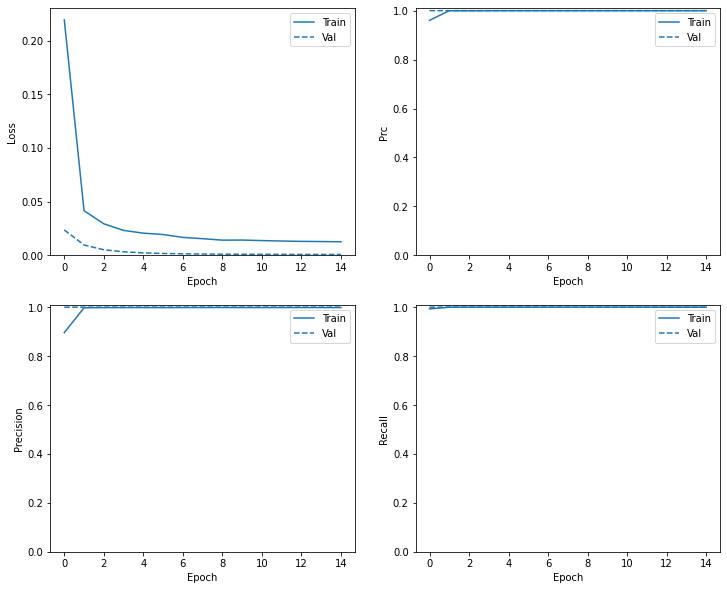

In [31]:
plot_metrics(weighted_history)

In [72]:
train_predictions_weighted = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = model.predict(test_features, batch_size=BATCH_SIZE)

In [73]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.4891032576560974
tp :  47406.0
fp :  10004.0
tn :  33.0
fn :  0.0
accuracy :  0.8258447647094727
precision :  0.82574462890625
recall :  1.0
auc :  0.6428132057189941
prc :  0.9096006155014038

Legitimate Transactions Detected (True Negatives):  33
Legitimate Transactions Incorrectly Detected (False Positives):  10004
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  47406
Total Fraudulent Transactions:  47406


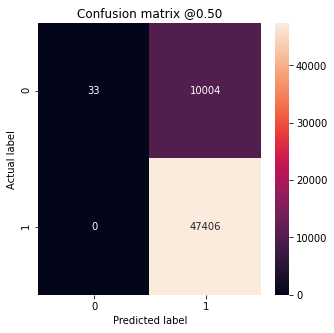

In [74]:
results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [39]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

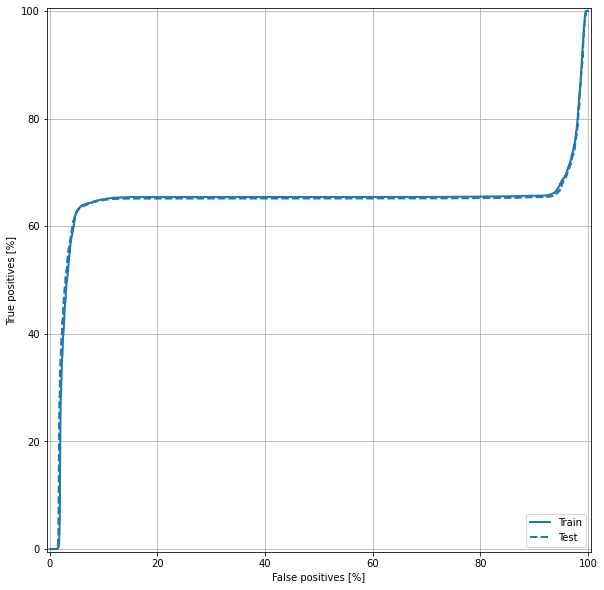

In [75]:
plot_roc("Train", train_labels, train_predictions_weighted, color=colors[0])
plot_roc("Test", test_labels, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [76]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

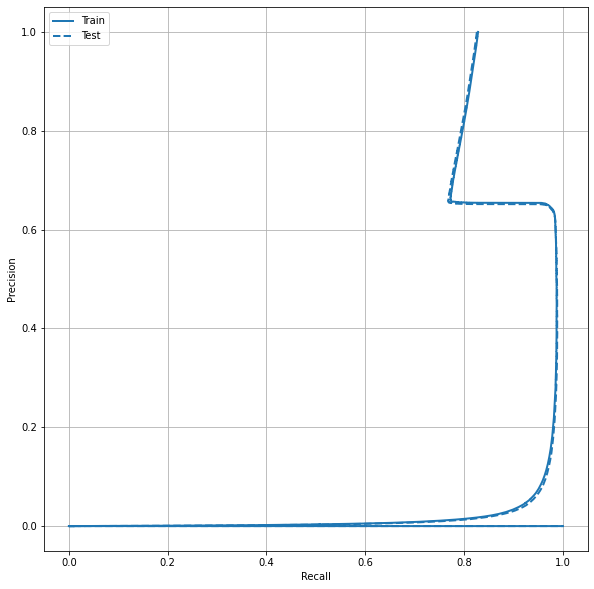

In [77]:
plot_prc("Train", train_labels, train_predictions_weighted, color=colors[0])
plot_prc("Test", test_labels, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='upper left')

**Preprocessing imbalanced dataset using oversampling**

In [61]:
bool_train_labels = train_labels != 0
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [63]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [64]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [91]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

49.0

In [92]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 4s 90ms/step - loss: 0.6809 - tp: 54735.2857 - fp: 2890.5238 - tn: 18433.9048 - fn: 3813.7619 - accuracy: 0.9196 - precision: 0.9510 - recall: 0.9374 - auc: 0.9748 - prc: 0.9870 - val_loss: 0.2341 - val_tp: 37059.0000 - val_fp: 27.0000 - val_tn: 7808.0000 - val_fn: 1060.0000 - val_accuracy: 0.9763 - val_precision: 0.9993 - val_recall: 0.9722 - val_auc: 0.9973 - val_prc: 0.9965
Epoch 2/1000
20/20 [==============================] - 1s 40ms/step - loss: 0.2370 - tp: 10364.0476 - fp: 561.3333 - tn: 10733.7143 - fn: 771.3810 - accuracy: 0.9340 - precision: 0.9424 - recall: 0.9239 - auc: 0.9829 - prc: 0.9717 - val_loss: 0.1071 - val_tp: 38105.0000 - val_fp: 11.0000 - val_tn: 7824.0000 - val_fn: 14.0000 - val_accuracy: 0.9995 - val_precision: 0.9997 - val_recall: 0.9996 - val_auc: 0.9991 - val_prc: 0.9987
Epoch 3/1000
20/20 [==============================] - 1s 38ms/step - loss: 0.1351 - tp: 10882.3810 - fp: 208.0000 - tn: 11051.3810 - fn:

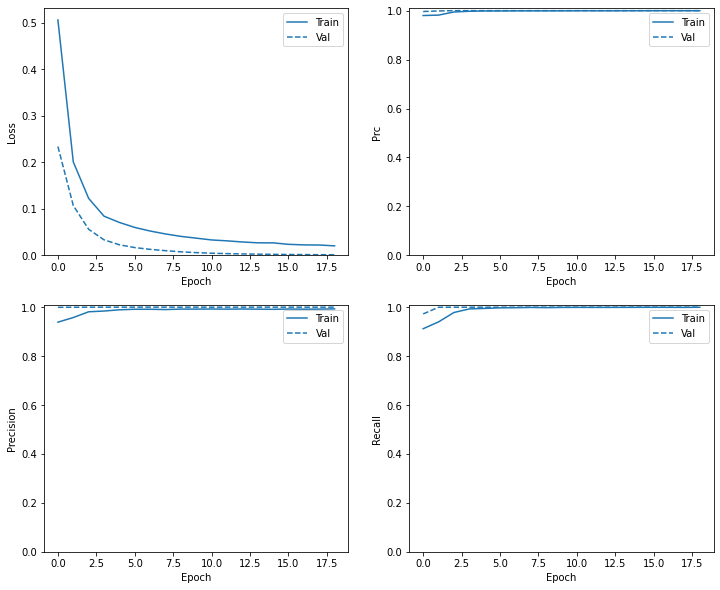

In [93]:
plot_metrics(resampled_history)

In [96]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.0075552016496658325
tp :  47396.0
fp :  0.0
tn :  10037.0
fn :  10.0
accuracy :  0.9998258948326111
precision :  1.0
recall :  0.9997890591621399
auc :  0.9999788403511047
prc :  0.9999960064888

Legitimate Transactions Detected (True Negatives):  10037
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  47396
Total Fraudulent Transactions:  47406


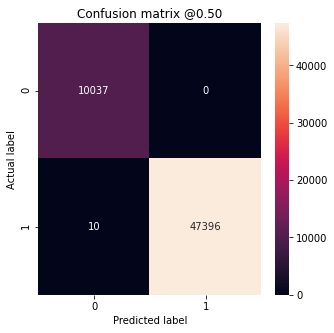

In [97]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

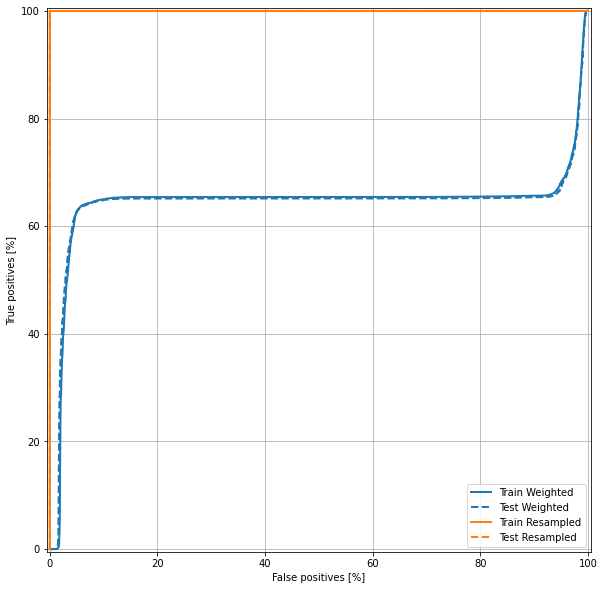

In [98]:
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[0])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[0], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[1])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[1], linestyle='--')
plt.legend(loc='lower right')


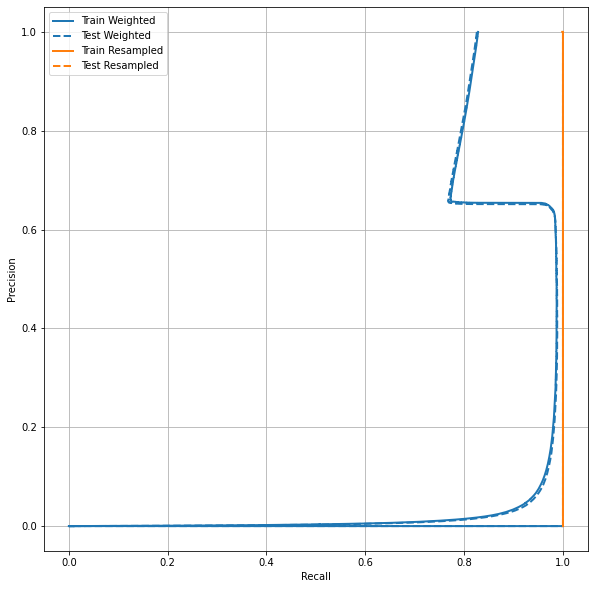

In [99]:
plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[0])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[0], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[1])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[1], linestyle='--')
plt.legend(loc='upper left')